In [2]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask, smaller_dtypes, make_df, hist2d_dask
import utils

import scipy.stats
import concurrent.futures
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask.distributed import progress
from dask import delayed
from yahist import Hist1D, Hist2D

In [3]:
set_plotting_style()

In [5]:
fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v11_unblind1fb_RAW_v11/*.root")
len(fnames)

29

In [37]:
# inspect one file to see branch names
# these are made in ../batch/babymaker.py
f = uproot.open(fnames[0])
t = f["Events"]
t.keys()

[b'run',
 b'luminosityBlock',
 b'event',
 b'pass_skim',
 b'pass_l1',
 b'pass_json',
 b'pass_fiducialgen',
 b'pass_excesshits',
 b'pass_fiducialgen_norho',
 b'dimuon_isos',
 b'dimuon_pt',
 b'dimuon_eta',
 b'dimuon_phi',
 b'dimuon_mass',
 b'absdphimumu',
 b'absdphimudv',
 b'minabsdxy',
 b'logabsetaphi',
 b'lxy',
 b'cosphi',
 b'pass_baseline',
 b'pass_baseline_iso',
 b'MET_pt',
 b'MET_phi',
 b'rho',
 b'nDV',
 b'nDV_passid',
 b'DV_x',
 b'DV_y',
 b'DV_z',
 b'DV_xError',
 b'DV_yError',
 b'DV_zError',
 b'DV_tracksSize',
 b'DV_chi2',
 b'DV_ndof',
 b'DV_isValidVtx',
 b'DV_passid',
 b'DV_rho',
 b'DV_rhoCorr',
 b'DV_inPixelRectangles',
 b'nJet',
 b'Jet_pt',
 b'Jet_eta',
 b'Jet_phi',
 b'Jet_m',
 b'nPV',
 b'PV_x',
 b'PV_y',
 b'PV_z',
 b'PV_tracksSize',
 b'PV_chi2',
 b'PV_ndof',
 b'PV_isValidVtx',
 b'nPVM',
 b'PVM_x',
 b'PVM_y',
 b'PVM_z',
 b'PVM_tracksSize',
 b'PVM_chi2',
 b'PVM_ndof',
 b'PVM_isValidVtx',
 b'nMuon',
 b'nMuon_passid',
 b'nMuon_passiso',
 b'Muon_pt',
 b'Muon_eta',
 b'Muon_phi',
 b'Mu

In [14]:
# make dataframe containing certain branches after certain cut

branches = ["dimuon_mass", "pass_skim","pass_baseline*","logabsetaphi","DV_rhoCorr","DV_x","DV_y"]
# cut = "pass_baseline_iso" # baseline selection with iso
# cut = "pass_baseline" # baseline selection without iso
cut = "pass_skim" # just requiring >=2 muons and >=1 DV. all events in root files already require the skim.


ddf = make_df(
    fnames[:2],
    branches = branches,
    cut = cut,
    chunksize = 1e6,
    use_dask = False,
)

In [40]:
print("ddf takes {:.1f}MB of memory and has {:.1f}M events".format(ddf.memory_usage().sum()/1e6, len(ddf)/1e6))
ddf

ddf takes 114.7MB of memory and has 5.0M events


,DV_rhoCorr,DV_x,DV_y,dimuon_mass,logabsetaphi,pass_baseline,pass_baseline_iso,pass_skim
0,0.167631,0.086135,-0.048654,3.154864,0.227088,False,False,True
1,0.198552,0.087744,-0.079827,2.996769,-1.596559,False,False,True
2,0.183203,0.095218,-0.064852,9.867033,0.050430,False,False,True
3,0.220374,0.081545,-0.101513,35.238350,-0.235280,False,False,True
4,0.184805,0.192533,-0.040665,3.015787,0.371367,False,False,True
...,...,...,...,...,...,...,...,...
4984922,0.007199,0.101038,-0.059451,9.693331,-0.320371,False,False,True
4984923,0.061270,0.100491,-0.003448,0.308788,0.260006,False,False,True
4984924,0.289391,0.361411,-0.177977,1.073388,0.350449,False,False,True
4984925,0.022139,0.082020,-0.047266,4.477600,0.591690,False,False,True


In [41]:
bins = np.linspace(-3,3,100)
h = Hist1D(ddf.query("(0 < DV_rhoCorr < 11) and pass_skim")["logabsetaphi"], bins=bins)

Text(0.5, 1.0, 'test')

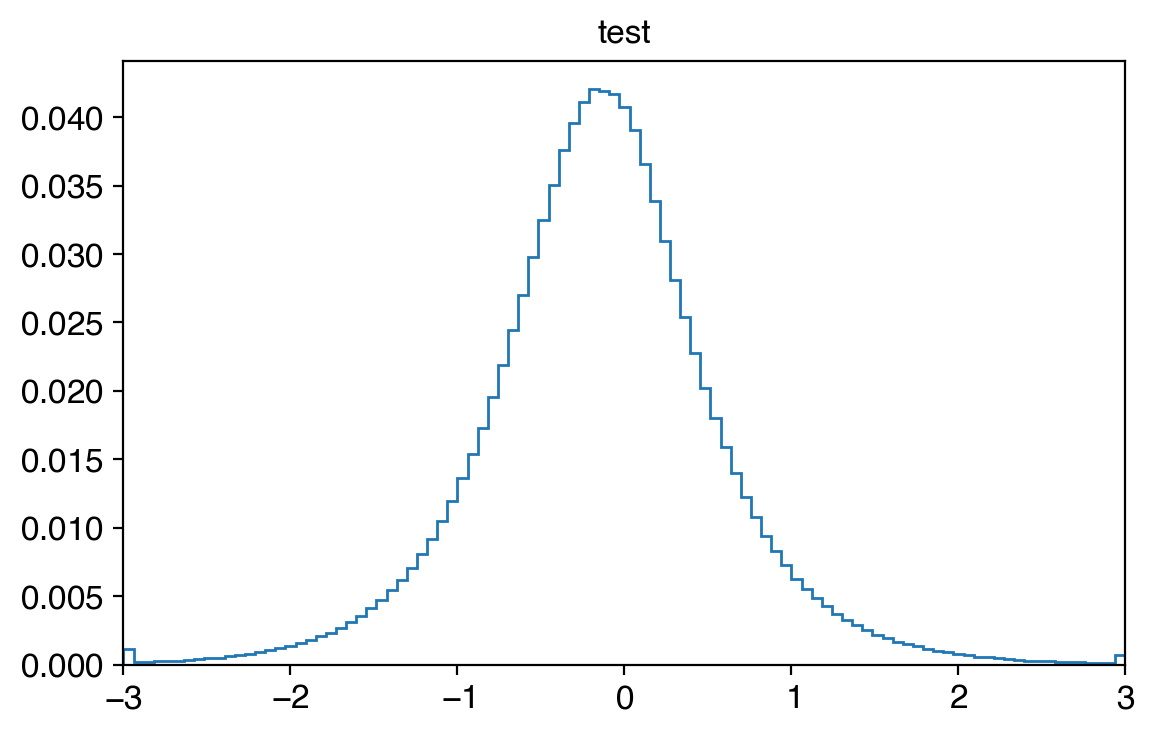

In [43]:
# exercise: try to reproduce the plot on the left of slide 3 of
# http://uaf-8.t2.ucsd.edu/~namin/dump/slides/DV_meeting_20Jan9.pdf#page=3
# ignore the signal histogram. Plot logabsetaphi for dimuon_mass > 5 in bins of DV_rhoCorr
# require the baseline selection with isolation
fig, ax = plt.subplots()
h.normalize().plot(ax=ax, histtype="step")
ax.set_title("test")

Text(0.5, 0, 'DV y (cm)')

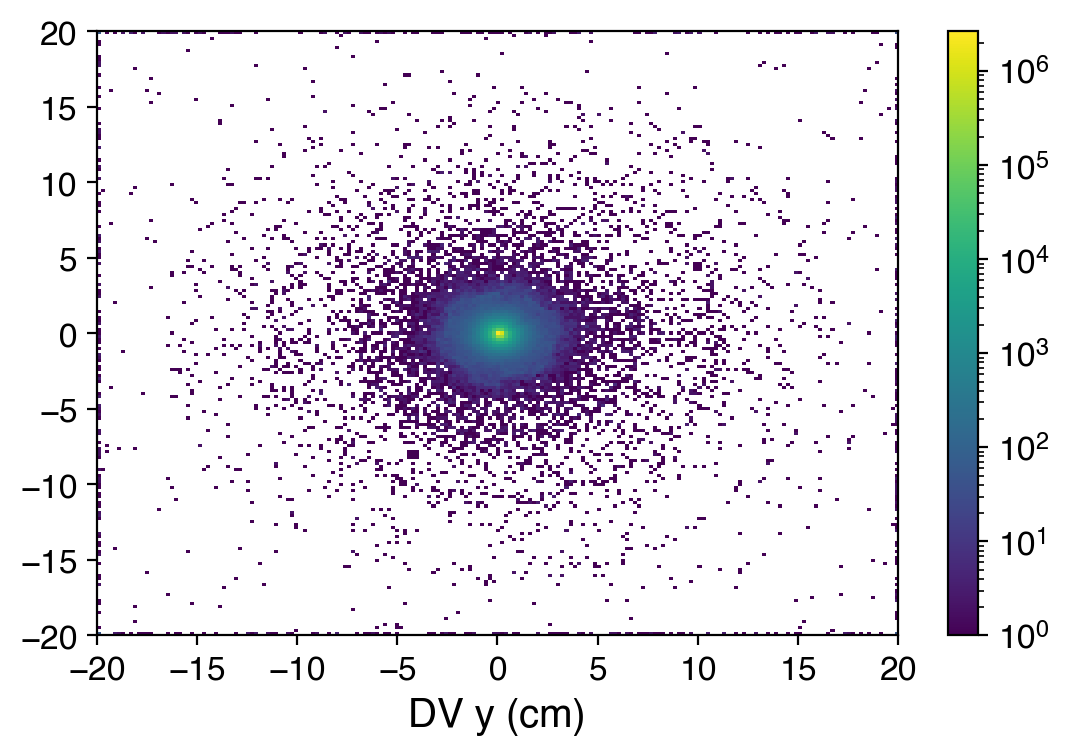

In [44]:
# exercise: try to make plots similar to the one on the left side of slide 5 of
# https://indico.cern.ch/event/864170/contributions/3642760/attachments/1949983/3236610/EXO_LLPupdate_19Nov22.pdf
bins = [np.linspace(-20,20,200), np.linspace(-20,20,200)]
df = ddf.query("pass_skim")
h = Hist2D(
    np.c_[
        df["DV_x"].values,
        df["DV_y"].values,
    ],
    bins=bins
)
fig, ax = plt.subplots()
h.plot(ax=ax, logz=True)
ax.set_xlabel("DV x (cm)")
ax.set_xlabel("DV y (cm)")

In [ ]:
# exercise: try to reproduce the plot on the left of slide 8 of
# https://indico.cern.ch/event/864170/contributions/3642760/attachments/1949983/3236610/EXO_LLPupdate_19Nov22.pdf
# (ignore signal)
# note that the cuts are baseline+isolation, DV_rhoCorr > 1, dimuon_mass > 5, for the full unblinded 1ifb 2018C data